In [20]:
import numpy as np
from mnist import MNIST
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
import random
from plotly.offline import plot, iplot

In [21]:
__mndata__ = MNIST(os.getcwd() +'\\image')
__train_image__, __train_label__ = __mndata__.load_training() #train & train_label
__test_image__, __test_label__ = __mndata__.load_testing() #test & test_label

In [33]:
class Utility:
    """This class warehouses the data and other general functions"""
    def __init__(self):
        self.train = np.asarray([np.reshape(x, (784)) for x in __train_image__]).astype('float64') #change train_image to numpy array #784 means 28 by 28 pixel
        self.train_label = np.asarray(__train_label__)
        self.test = np.asarray([np.reshape(x, (784)) for x in __test_image__]).astype('float64') #change test_image to numpy array
        self.test_label = np.asarray(__test_label__)
        self.n_class = list(range(10)) #class labels
        
    def confusionMatrix(self, actual, predict, print_cfm=True, print_err_digit=True):
        cfm = pd.DataFrame(confusion_matrix(actual, predict))
        err_all = round((1 - sum(np.diagonal(cfm)) / len(predict)) * 100, 4)
        error_digit = []
        for i in self.n_class:
            error_digit.append(round(1 - cfm.iloc[i,i] / sum(cfm.iloc[i,:]), 4) * 100)

        tab_error = pd.DataFrame(columns=['digit', 'error per digit in %'])
        tab_error['digit'] = self.n_class
        tab_error['error per digit in %'] = error_digit

        if print_cfm:
            print('Testing Confusion Matrix: Actual vs. Prediction')
            display(cfm)

        if print_err_digit:
            print('% error per digit')
            display(tab_error)
            print('\nThe overall testing error is {}%'.format(err_all))

        return cfm, tab_error, err_all


    def nFoldCV_NB(self, train, train_label, smoothings, kFolds):
        stra_all = self.folds_stratify(nSample=len(train), kFolds=kFolds)
        ave_test_err = []
        for s, sVal in enumerate(smoothings):
            test_err = []
            for k in range(kFolds):
                stra = stra_all.copy()
                te = train[stra[k]]
                te_lb = train_label[stra[k]]
                del stra[k]  # del test list
                tr = train[list(chain.from_iterable(stra))]
                tr_lb = train_label[list(chain.from_iterable(stra))]
                nb = NaiveBayes(train=tr, train_lb=tr_lb, test=te, test_lb=te_lb, smoothing=sVal)
                nb.predict()
                conf = self.confusionMatrix(te_lb, nb.pred, False, False)
                test_err.append(conf[2])

            ave_test_err.append(np.mean(test_err))

        return ave_test_err

    def folds_stratify(self, nSample, kFolds):
        """This return kfold stratification"""
        foldSize = round(nSample / kFolds, 0)
        randomList = list(range(0, nSample))
        random.shuffle(randomList)
        stratify = []

        for k in range(0, kFolds):
            strt = int(k * foldSize)
            end = int((k + 1) * foldSize)
            if k == (kFolds - 1):
                end = nSample
            stratify.append(list(randomList)[strt:end])

        return stratify
    
    def CV_plot(k_error, k_list, title):
        k_error = np.round(k_error, 4)
        best_k = k_list[np.argmin(k_error)]
        err_best_k = np.min(k_error)
        plt.plot(k_list, k_error, '-gD', color='black')
        ax = plt.subplot(111)
        ax.set_xticks(k_list, k_list)
        plt.ylabel('% Error')
        plt.xlabel(title)
        plt.title('Plot of ' + title + ' vs. average 5 foldCV error')
        plt.show()
        print('The best value of ' + title + ' is {} with an error of {}%'.format(best_k, err_best_k))
        print('\n' + title + ' = {} will be used to model the entire training set and prediction on testing set:'.format(best_k))
        return best_k, err_best_k
        
    def images_plot(imageData, prob=1):
        classes = ["P(x|c=0)", "P(x|c=1)", "P(x|c=2)", "P(x|c=3)", "P(x|c=4)", "P(x|c=5)", "P(x|c=6)", "P(x|c=7)",
                   "P(x|c=8)", "P(x|c=9)"]

        num_classes = len(classes)
        plt.subplots(figsize=(15, 2))
        for y, cls in enumerate(classes):
            plt_idx = y + 1
            plt.subplot(1, num_classes, plt_idx)
            if prob:
                plt.imshow(imageData[y].reshape((28, 28)))
            else:
                plt.imshow(imageData[y].reshape(785, 1)[1:785].reshape((28, 28)))
            plt.axis("off")
            plt.title(cls)

        plt.tight_layout()
        plt.show()
        
#End of Class Utility

class NaiveBayes:
    """This class warehouses the Naive bayes classifier"""
    def __init__(self, train, train_lb, test, test_lb, smoothing, jupyter=True, plot_dis=False):
        self.n_class = np.unique(train_lb)
        self.tr = train
        self.te = test
        self.tr_lb = train_lb
        self.te_lb = test_lb
        self.plot_dis = plot_dis
        self.jupyter = jupyter
        self.smoothing = smoothing
        if jupyter:
            self.plotly = iplot
        else:
            self.plotly = plot

    def mean_std_prior(self):
        """Mean and Std per feature per class, and prior per class"""
        self.mean, self.std, self.priors, self.count = [], [], [], []
        for i, val in enumerate(self.n_class):
            sep = [self.tr_lb == val] #separated
            self.count.append(len(self.tr_lb[sep]))
            self.priors.append(len(self.tr_lb[sep]) / len(self.tr_lb))
            self.mean.append(np.mean(self.tr[sep], axis=0))
            self.std.append(np.std(self.tr[sep], axis=0))

        if self.plot_dis:
            bar_data = Bar(x=list(range(len(self.count))), y=self.count)
            data_plt = Data([bar_data])
            layout = Layout(yaxis=YAxis(title='counts'), xaxis=XAxis(title='classes', dtick=1),
                            title='Class distribution in Train set')
            fig = Figure(data=data_plt, layout=layout)
            self.plotly(fig)

    def predict(self):
        """prediction: by summing the natural log of all the conditional probability given the class."""
        str_time = time()
        self.mean_std_prior()
        self.pred = []
        self.likelihood = []
        self.logsum_chk = []
        for n in range(len(self.te_lb)):
            classifier = []
            sample = self.te[n] #test sample
            likelih = []
            for i, val in enumerate(self.n_class):
                mean = self.mean[i]
                var = np.square(self.std[i]) + self.smoothing
                prob = 1 / np.sqrt(2 * np.pi * var) * np.exp(-np.square(sample - mean)/(2 * var))
                result = np.sum(np.log(prob)) #, np.log(self.priors[i])) #not needed, we assume equal prior
                classifier.append(result)
                likelih.append(prob)

            self.pred.append(np.argmax(classifier))
            self.likelihood.append(likelih)
            self.logsum_chk.append(classifier)

        self.end_time = time() - str_time

#End of Class Naive Bayes

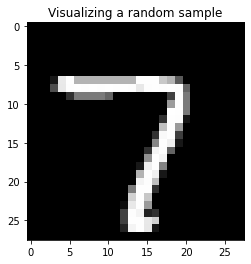

In [23]:
util = Utility()

plt.imshow(np.reshape(util.train[random.randint(1,1000)], [28,28]), cmap='Greys_r'); plt.title('Visualizing a random sample'); plt.show()

In [27]:
util = Utility()
smoothings_nb = list(tuple(range(500, 2100, 100)))
kfold_nb = util.nFoldCV_NB(util.train, util.train_label, smoothings_nb, kFolds=5)

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:74: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "-gD" (-> color='g'). The keyword argument will take precedence.



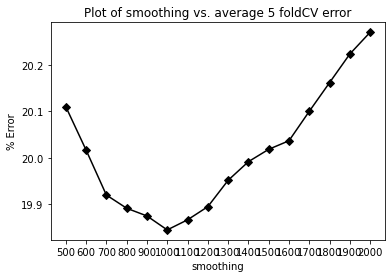

The best value of smoothing is 1000 with an error of 19.845%

smoothing = 1000 will be used to model the entire training set and prediction on testing set:


In [30]:
sm_plot = Utility.CV_plot(kfold_nb, smoothings_nb, 'smoothing')

In [31]:
util = Utility()
best_s = smoothings_nb[np.argmin(kfold_nb)]
nb = NaiveBayes(train=util.train, train_lb=util.train_label, test=util.test, test_lb=util.test_label, smoothing=best_s)
nb.predict()
conf_matix = util.confusionMatrix(util.test_label, nb.pred)

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:127: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:128: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\11071\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:129: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.arra

Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,902,0,0,4,1,11,20,1,37,4
1,0,1096,1,4,0,0,6,0,28,0
2,15,36,778,31,9,5,59,14,79,6
3,6,34,26,814,0,18,15,11,44,42
4,4,6,5,0,640,4,22,0,19,282
5,19,28,7,94,23,574,24,11,64,48
6,12,22,12,1,8,24,865,0,13,1
7,1,38,8,4,20,0,1,837,25,94
8,8,67,8,36,11,17,12,4,742,69
9,6,16,3,9,38,1,0,15,20,901


% error per digit


,digit,error per digit in %
0,0,7.96
1,1,3.44
2,2,24.61
3,3,19.41
4,4,34.83
5,5,35.65
6,6,9.71
7,7,18.58
8,8,23.82
9,9,10.70



The overall testing error is 18.51%


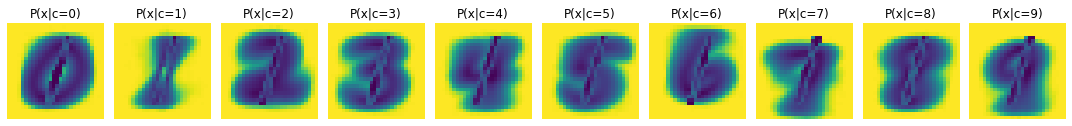

In [34]:
Utility.images_plot(nb.likelihood[2])

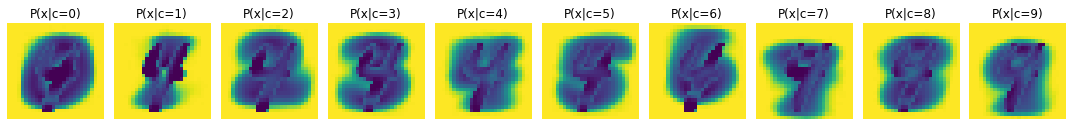

In [35]:
Utility.images_plot(nb.likelihood[9997])